<h1 style="background-color:rgb(67, 77, 86);
           font-size:300%;
           font-style: oblique;
           color:white;
           text-align:center;
           margin: auto;
           padding: 20px;">Predicting Bank Churners</h1>

<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Chapter 3: Data Cleaning</h2>

<a id='1.1'>
    <h2 style='font-size:180%;'>
        Mission</h2></a>

<figure>
    <blockquote cite='https://www.kaggle.com/sakshigoyal7/credit-card-customers/tasks?taskId=2729'>
        <p style='font-size:110%;
                  color:hsl(208, 12%, 30%);'><i>Our top priority in this business problem is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won't harm our business. But predicting churning customers as non-churning will do. So recall needs to be higher. Till now, I have managed to get a recall of 62%.</i></p>
    </blockquote>
    <figcaption>—Sakshi Goyal, <cite>Credit Card Customers, Kaggle</cite></figcaption>

<h2 style='font-size:180%;'>
    Table of Contents
</h2>

* [Initial Preparation](#4)
    * [Libraries](#4.1)
    * [Data Loading](#4.2)
* [Normality Test](#5)
    * [Histograms](#5.1)
    * [Skewness & Kurtosis](#5.2)
    * [QQ Plots](#5.3)
    * [Statistical Tests](#5.4)
        * [D'Agostino's K Square](#5.4.1)
        * [Anderson Test](#5.4.2)
        * [Jarque–Bera Test](#5.4.3)
* [Baseline Models](#6)
    * [Logistic Regression](#6.1)
    * [Gradient Boosting Classifier](#6.2)
* [Outlier Treatment](#7)
    * [Isolation Forest](#7.1)
    * [Fit on All Classes](#7.2)
        * [Logistic Regression](#7.2.1)
        * [Gradient Boosting Classifier](#7.2.2)
    * [Evaluate Results](#7.3)
            

<a id='4'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Initial Preparation
    </h2>
</a>

<a id='4.1'>
    <h2 style='font-size:210%;'>
        Libraries
    </h2>
</a>

In [1]:
# general
from scipy import stats 
import numpy as np
import pandas as pd
import random as rd
import copy

# data visualization
import matplotlib.pyplot as plt

# statistical tests
import statsmodels.api as sm
from scipy.stats import (
    normaltest, anderson, jarque_bera)

# machine learning
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (
    train_test_split, cross_validate, RepeatedStratifiedKFold, RandomizedSearchCV) # cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (GradientBoostingClassifier, IsolationForest)
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score,
    classification_report, precision_recall_fscore_support, confusion_matrix, SCORERS)
from numpy import mean
from numpy import std

# settings
%matplotlib inline
pd.options.display.float_format = "{:,.2f}".format

# saving
import os

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Data Loading
    </h2>
</a>

In [2]:
# load data
d = pd.read_csv('source/d_num.csv')
d.head(3)

,churn,age,gender,dependents,prod_ct,mo_on_book,mo_inactive_r12,contr_ct_r12,revbal_avg_r12,credlim_avg_r12,...,marstat_Married,marstat_Single,marstat_Unknown,card_Blue,card_Gold,card_Platinum,card_Silver,educ,inc,tx_amt_pertx_r12
0,0,45,1,3,5,39,1,3,777.00,"12,691.00",...,1,0,0,1,0,0,0,1,3,27.24
1,0,49,0,5,6,44,1,2,864.00,"8,256.00",...,0,1,0,1,0,0,0,3,1,39.12
2,0,51,1,3,4,36,1,0,0.00,"3,418.00",...,1,0,0,1,0,0,0,3,4,94.35


In [3]:
# confirm data consists only of numerical data types
d.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

<a id='5'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Normality Test
    </h2>
</a>

Evaluating normality of data is critical to determining whether to use parametric or nonparametric methods. Parametric methods assume a a known and specific distribution of data which is often a Gaussian. A nonparametric method must be used if the normality assumption is violated. If one uses a method that assume a Gaussian distribution but the data is not Gaussian, the results may be misleading or plain inaccurate. In this section, we test the normality of the ordinal variables to check if our data is sufficiently-normal for us to use parametric methods.

<a id='5.1'>
    <h2 style='font-size:210%;'>
        Histograms
    </h2>
</a>

Although none of the features looked quite normal in the Visualization section, we can confirm our judgment with statistics and formal normality tests. First, let's review the histograms of the ordinal variables in the data to spot check some promising candidates.

We can spot some multinomial (`tx_amt_r12`, `tx_amt_pertx_r12`) and exponential distributions (`credlim_avg_r12`,`opentobuy_avg_r12`) as well as roughly normal distributions (`chng_tx_amt_q4_q1`, `chng_tx_ct_q4_q1`) among the continuous variables.

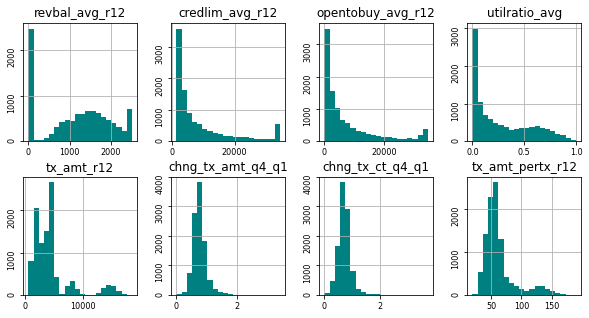

In [4]:
# histograms for continuous variables
r, c = 2, 4
d.select_dtypes('float').hist(
    xlabelsize=8, ylabelsize=8, 
    yrot=90, 
    layout=(r, c), figsize=(c*2.5, r*2.5),
    color='teal', bins=20)
plt.show()

Among the discrete variables, `age` and `dependents` seem to be sufficiently-normal.

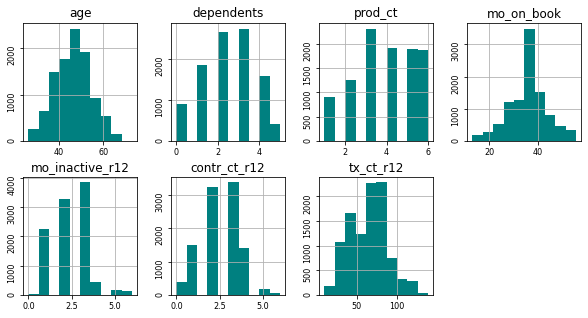

In [5]:
# histograms for discrete variables
var_list = ['age', 'dependents', 'prod_ct', 'mo_on_book',
            'mo_inactive_r12', 'contr_ct_r12', 
            'tx_ct_r12']
d[var_list].hist(
    xlabelsize=8, ylabelsize=8, 
    yrot=90, 
    layout=(r, c), figsize=(c*2.5, r*2.5),
    color='teal', bins=10)
plt.show()

<a id='5.2'>
    <h2 style='font-size:210%;'>
        Skewness & Kurtosis
    </h2>
</a>

Skewness measures the skew or asymmetry of the distribution (left or right) while kurtosis measures the thickness of the distribution's tails compared to a Gaussian distribution. These are quick and simple statistical tests for normality. A perfectly normal distribution has a skew of $0$ and kurtosis of $3$ (or the fisher or excess kurtosis of $0$). A reasonably normal range for both skew and kurtosis is $[-1, 1]$.

In [6]:
# `pandas.df.skew`
print('Variables with Skewness < |1|')
d.skew(axis=0, skipna=True)[d.skew(axis=0, skipna=True).between(-1,1)]

Variables with Skewness < |1|


age               -0.03
gender             0.12
dependents        -0.02
prod_ct           -0.16
mo_on_book        -0.11
mo_inactive_r12    0.63
contr_ct_r12       0.01
revbal_avg_r12    -0.15
utilratio_avg      0.72
tx_ct_r12          0.15
marstat_Married    0.15
marstat_Single     0.45
educ               0.31
inc                0.47
dtype: float64

In [7]:
# `pandas.df.kurt` calculates the fisher method
print('Variables with Kurtosis < |1|')
d.kurt(axis=0, skipna=True)[d.kurt(axis=0, skipna=True).between(-1,1)]

Variables with Kurtosis < |1|


age             -0.29
dependents      -0.68
mo_on_book       0.40
contr_ct_r12     0.00
utilratio_avg   -0.79
tx_ct_r12       -0.37
inc             -0.91
dtype: float64

Both `age` and `dependents` are slightly platykurtic meaning that they have thinner tails with values more spread out compared to a normal distribution. The negative kurtosis between $[-1, 1]$ falls within the general guideline for validating sufficiently normal data.

In [8]:
# round(stats.kurtosis(d['age'], fisher=True),2)

<a id='5.3'>
    <h2 style='font-size:210%;'>
        QQ Plots
    </h2>
</a>

The Quantile-Quantile Plot known as the "QQ Plot" provides a visual representation of normality by comparing theoretical quantiles and the actual quantiles of our variable. The distance between the scatter plot and the red diagonal line represents deviation from a normal distribution. The QQ plot does a much better job in visualizing normality of a variable compared to a histogram or a box plot.

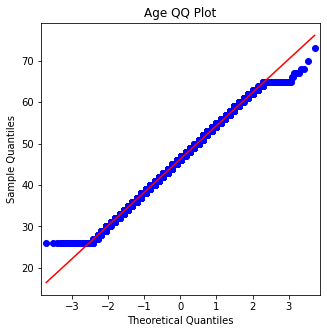

In [9]:
# import statsmodels.api as sm
plt.rc('figure',figsize=(5,5))
my_data = d['age']
sm.qqplot(my_data, line='s')
plt.title('Age QQ Plot')
plt.show()

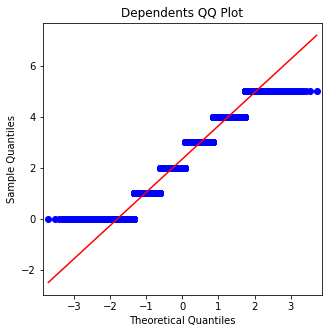

In [10]:
# import statsmodels.api as sm
plt.rc('figure',figsize=(5,5))
my_data = d['dependents']
sm.qqplot(my_data, line='s')
plt.title('Dependents QQ Plot')
plt.show()

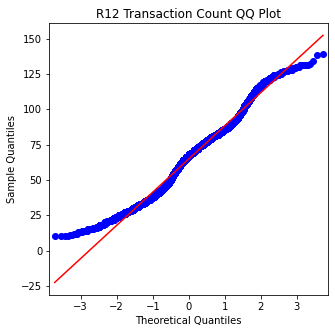

In [11]:
# import statsmodels.api as sm
plt.rc('figure',figsize=(5,5))
my_data = d['tx_ct_r12']
sm.qqplot(my_data, line='s')
plt.title('R12 Transaction Count QQ Plot')
plt.show()

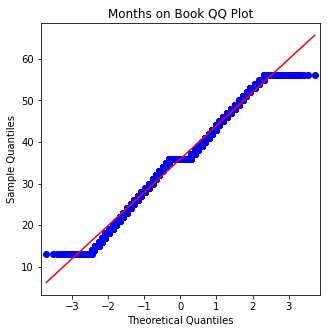

In [12]:
# import statsmodels.api as sm
plt.rc('figure',figsize=(5,5))
my_data = d['mo_on_book']
sm.qqplot(my_data, line='s')
plt.title('Months on Book QQ Plot')
plt.show()

All four plots show pretty good signs of normality except the two extremes of the distribution which is indicative of high kurtosis mentioned above.

<a id='5.4'>
    <h2 style='font-size:210%;'>
        Statistical Tests
    </h2>
</a>

In this section, I will try three different statistical normality tests: `D'Agostino's K Square`, `Anderson Test`, and `Jarque-Bera` to examine if the statistical normality test results are also aligned with the normality patterns we observed in the previous section. These normality tests can be used to check if the the more promising candidates are sufficiently normal for us to proceed with parametric methods, most of which require normality assumptions.

By the Central Limit Theorem, as $n$ gets large the distribution of sample means will approximate a normal distribution. Thus, formal statistical tests to check the normality of distributions are not as useful with the full data. For this reason and for demonstration purposes, I take a sample of randomly selected $800$ for all three normality tests. This way, the tests will yield results that are usable for the practical purposes of our analysis.

First, let's take a look at D'Agostino's K Square test which calculates kurtosis and skewness of the data to determine if the distribution deviates from the normal distribution.

In [13]:
sample_n = 800

<a id='5.4.1'>
    <h2 style='font-size:180%;'>
        D'Agostino's K Square
    </h2>
</a>

In [14]:
# from scipy.stats import normaltest
stat, p = normaltest(d['age'].sample(sample_n, random_state=1))
print('D\'Agostino\'s K Square Results for:')
print('%s \nStatistics=%.3f, p=%.3f' % ('age', stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0) \n')
else:
    print('Sample does not look Gaussian (reject H0) \n')

D'Agostino's K Square Results for:
age 
Statistics=3.808, p=0.149
Sample looks Gaussian (fail to reject H0) 



In [15]:
# from scipy.stats import normaltest
stat, p = normaltest(d['dependents'].sample(sample_n, random_state=1))
print('D\'Agostino\'s K Square Results for:')
print('%s \nStatistics=%.3f, p=%.3f' % ('dependents', stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0) \n')
else:
    print('Sample does not look Gaussian (reject H0) \n')

D'Agostino's K Square Results for:
dependents 
Statistics=28.351, p=0.000
Sample does not look Gaussian (reject H0) 



In [16]:
# from scipy.stats import normaltest
stat, p = normaltest(d['tx_ct_r12'].sample(sample_n, random_state=1))
print('D\'Agostino\'s K Square Results for:')
print('%s \nStatistics=%.3f, p=%.3f' % ('tx_ct_r12', stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0) \n')
else:
    print('Sample does not look Gaussian (reject H0) \n')

D'Agostino's K Square Results for:
tx_ct_r12 
Statistics=4.431, p=0.109
Sample looks Gaussian (fail to reject H0) 



In [17]:
# from scipy.stats import normaltest
stat, p = normaltest(d['mo_on_book'].sample(sample_n, random_state=1))
print('D\'Agostino\'s K Square Results for:')
print('%s \nStatistics=%.3f, p=%.3f' % ('mo_on_book', stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0) \n')
else:
    print('Sample does not look Gaussian (reject H0) \n')

D'Agostino's K Square Results for:
mo_on_book 
Statistics=1.948, p=0.378
Sample looks Gaussian (fail to reject H0) 



<a id='5.4.2'>
    <h2 style='font-size:180%;'>
        Anderson Test
    </h2>
</a>

In [18]:
# from scipy.stats import anderson
result = anderson(d['age'].sample(sample_n, random_state=1))
print('Anderson Test Results for:')
print('%s \nStatistics=%.3f' % ('age', round(result.statistic,3)))

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks Gaussian (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look Gaussian (reject H0)' % (sl, cv))

Anderson Test Results for:
age 
Statistics=0.929
15.000: 0.573, data does not look Gaussian (reject H0)
10.000: 0.653, data does not look Gaussian (reject H0)
5.000: 0.783, data does not look Gaussian (reject H0)
2.500: 0.913, data does not look Gaussian (reject H0)
1.000: 1.087, data looks Gaussian (fail to reject H0)


In [19]:
# from scipy.stats import anderson
result = anderson(d['dependents'].sample(sample_n, random_state=1))
print('Anderson Test Results for:')
print('%s \nStatistics=%.3f' % ('dependents', round(result.statistic,3)))

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks Gaussian (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look Gaussian (reject H0)' % (sl, cv))

Anderson Test Results for:
dependents 
Statistics=21.069
15.000: 0.573, data does not look Gaussian (reject H0)
10.000: 0.653, data does not look Gaussian (reject H0)
5.000: 0.783, data does not look Gaussian (reject H0)
2.500: 0.913, data does not look Gaussian (reject H0)
1.000: 1.087, data does not look Gaussian (reject H0)


In [20]:
# from scipy.stats import anderson
result = anderson(d['tx_ct_r12'].sample(sample_n, random_state=1))
print('Anderson Test Results for:')
print('%s \nStatistics=%.3f' % ('tx_ct_r12', round(result.statistic,3)))

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks Gaussian (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look Gaussian (reject H0)' % (sl, cv))

Anderson Test Results for:
tx_ct_r12 
Statistics=3.964
15.000: 0.573, data does not look Gaussian (reject H0)
10.000: 0.653, data does not look Gaussian (reject H0)
5.000: 0.783, data does not look Gaussian (reject H0)
2.500: 0.913, data does not look Gaussian (reject H0)
1.000: 1.087, data does not look Gaussian (reject H0)


In [21]:
# from scipy.stats import anderson
result = anderson(d['mo_on_book'].sample(sample_n, random_state=1))
print('Anderson Test Results for:')
print('%s \nStatistics=%.3f' % ('mo_on_book', round(result.statistic,3)))

for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks Gaussian (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look Gaussian (reject H0)' % (sl, cv))

Anderson Test Results for:
mo_on_book 
Statistics=6.569
15.000: 0.573, data does not look Gaussian (reject H0)
10.000: 0.653, data does not look Gaussian (reject H0)
5.000: 0.783, data does not look Gaussian (reject H0)
2.500: 0.913, data does not look Gaussian (reject H0)
1.000: 1.087, data does not look Gaussian (reject H0)


<a id='5.4.3'>
    <h2 style='font-size:180%;'>
        Jarque–Bera Test
    </h2>
</a>

In [22]:
# from scipy.stats import jarque_bera
my_data = d['age'].sample(sample_n, random_state=1)
stat, p = jarque_bera(my_data)
print('Jarque–Bera Test Results for:')
print('%s \nStatistics=%.3f, p=%.3f' % ('age', stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0) \n')
else:
    print('Sample does not look Gaussian (reject H0) \n')

Jarque–Bera Test Results for:
age 
Statistics=3.493, p=0.174
Sample looks Gaussian (fail to reject H0) 



In [23]:
# from scipy.stats import jarque_bera
my_data = d['dependents'].sample(sample_n, random_state=1)
stat, p = jarque_bera(my_data)
print('Jarque–Bera Test Results for:')
print('%s \nStatistics=%.3f, p=%.3f' % ('dependents', stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0) \n')
else:
    print('Sample does not look Gaussian (reject H0) \n')

Jarque–Bera Test Results for:
dependents 
Statistics=13.932, p=0.001
Sample does not look Gaussian (reject H0) 



In [24]:
# from scipy.stats import jarque_bera
my_data = d['tx_ct_r12'].sample(sample_n, random_state=1)
stat, p = jarque_bera(my_data)
print('Jarque–Bera Test Results for:')
print('%s \nStatistics=%.3f, p=%.3f' % ('tx_ct_r12', stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0) \n')
else:
    print('Sample does not look Gaussian (reject H0) \n')

Jarque–Bera Test Results for:
tx_ct_r12 
Statistics=4.252, p=0.119
Sample looks Gaussian (fail to reject H0) 



In [25]:
# from scipy.stats import jarque_bera
my_data = d['mo_on_book'].sample(sample_n, random_state=1)
stat, p = jarque_bera(my_data)
print('Jarque–Bera Test Results for:')
print('%s \nStatistics=%.3f, p=%.3f' % ('mo_on_book', stat, p))
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0) \n')
else:
    print('Sample does not look Gaussian (reject H0) \n')

Jarque–Bera Test Results for:
mo_on_book 
Statistics=1.883, p=0.390
Sample looks Gaussian (fail to reject H0) 



All three test results indicate that under certain thresholds of $n$ and test statistic `age` is normal but `dependents` is not. `Anderson` is the most stringent as none of the variables look Gaussian under its assumptions. However, both `D'Agostino's K Square` and `Jarque-Bera` conclude that `age`, `tx_ct_r12`, `mo_on_book` are normal enough, despite the pretty low p-values in the range of tens for `age`, `mo_on_book`. From these tests, one can conclude that `age` and `mo_on_book` may be normal enough. 

Based on this result, it might be beneficial to standardize `age` and `mo_on_book` but normalize all other variables in the feature transformation section before feature selection. Before we normalize, however, we should treat the outliers as most normalization methods are sensitive to outliers.

<a id='6'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Baseline Models
    </h2>
</a>

To identify and treat outliers, we start with two baseline models:

1. Logistic Regression
2. XGBoost Classifier

The assumption is that Logistic Regression will benefit from the removal of outliers much more than does XGBoost Classifier as the former makes a strong assumption of the data's functional form, and the decision boundary is sensitive to minimum and maximum values in the data.

<a id='6.1'>
    <h2 style='font-size:210%;'>
        Train-Test Split
    </h2>
</a>

In [26]:
# split train and test
d = d.values
x, y = d[:,1:], d[:,:1].ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

In [27]:
print(f'Feature Dimension: {x.shape}\t Label Dimension: : {y.shape}')

Feature Dimension: (10127, 26)	 Label Dimension: : (10127,)


In [28]:
print(f'Percentage of Churn for the Full Data: {round(y.sum()/len(y),4)*100}%')

Percentage of Churn for the Full Data: 16.07%


In [29]:
print(f'Train Feature Dimension: {x_train.shape}\t Train Label Dimension: : {y_train.shape}')
print(f'Test Feature Dimension: {x_test.shape}\t Test Label Dimension: : {y_test.shape}')

Train Feature Dimension: (8101, 26)	 Train Label Dimension: : (8101,)
Test Feature Dimension: (2026, 26)	 Test Label Dimension: : (2026,)


In [30]:
print(f"""Percentage of Churn for Train Set: {round(y_train.sum()/len(y_train),4)*100}%
Percentage of Churn for Test Set: {round(y_test.sum()/len(y_test),4)*100}%""")

Percentage of Churn for Train Set: 16.07%
Percentage of Churn for Test Set: 16.04%


<a id='6.2'>
    <h2 style='font-size:210%;'>
        Logistic Regression
    </h2>
</a>

First, we fit the logistic regression model. Although this model is more sensitive to multicollinearity, we will ignore this factor as this section's goal is to demonstrate the effect of removing outliers only. Multicolinearity will be taken care of in the feature selection section. Other factors that affect the model's performance such as model selection and hyperparameter tuning etc. will also be discussed in the later sections.

<a id='6.2.1'>
    <h2 style='font-size:180%;'>
        Model Attributes
    </h2>
</a>

In [31]:
print("Logistic Regression Parameters:")
LogisticRegression().get_params()

Logistic Regression Parameters:


{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [32]:
LogisticRegression_params = LogisticRegression().get_params()
print(f"""Default Param Values:
  `C`:\t\t{LogisticRegression_params["C"]} 
  `solver`:\t{LogisticRegression_params["solver"]}
  `max_iter`:\t{LogisticRegression_params["max_iter"]}
     """)

Default Param Values:
  `C`:		1.0 
  `solver`:	lbfgs
  `max_iter`:	100
     


<a id='6.2.2'>
    <h2 style='font-size:180%;'>
        Model Fit & Evaluation
    </h2>
</a>

Notes on L1 and L2 regularization:
> *Introducing a penalty to the sum of the weights means that the model has to "distribute" its weights optimally, so naturally most of this "resource" will go to the simple features that explain most of the variance, with complex features getting small or zero weights.*

[Edden Gerber, *Comment on a Medium Article*](https://medium.com/@edden.gerber/thanks-for-the-article-1003ad7478b2)

In [33]:
# %%timeit
# logit = LogisticRegression(solver='saga', class_weight='balanced', C=0.1, max_iter=10000, random_state=1)
# scaler = MinMaxScaler() # logit requires scaling to behave somewhat more decently
# pipeline = Pipeline([('s', scaler),('m', logit)])
# pipeline.fit(x_train, y_train)
# yhat = pipeline.predict(x_test)

In [34]:
# 75.1 ms ± 4.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

In [35]:
# define the modeling pipeline
logit = LogisticRegression(solver='saga', class_weight='balanced', C=0.1, max_iter=10000, random_state=1)
scaler = MinMaxScaler() # logit requires scaling to behave somewhat more decently
pipeline = Pipeline([('s', scaler),('m', logit)])

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model
m_scores = cross_validate(
    pipeline, x_train, y_train, 
    scoring=['accuracy','precision','recall','f1'], 
    cv=cv, n_jobs=-1)

In [36]:
# summarize the results
fit_time = round(mean(m_scores['fit_time']), 4)
fit_time_sd = round(std(m_scores['fit_time']), 4)
score_time = round(mean(m_scores['score_time']), 4)
score_time_sd = round(std(m_scores['score_time']), 4)
accuracy = round(mean(m_scores['test_accuracy']), 4)
accuracy_sd = round(std(m_scores['test_accuracy']), 4)
precision = round(mean(m_scores['test_precision']), 4)
precision_sd = round(std(m_scores['test_precision']), 4)
recall = round(mean(m_scores['test_recall']), 4)
recall_sd = round(std(m_scores['test_recall']), 4)
f1 = round(mean(m_scores['test_f1']), 4)
f1_sd = round(std(m_scores['test_f1']), 4)

print("""Logistic Regression on Validation Set
      Fit Time:\t  %.2f (%.2f)
      Score Time:  %.2f (%.2f)
      Accuracy:\t  %.2f (%.2f)%% 
      Precision:  %.2f (%.2f)%%  
      Recall:\t  %.2f (%.2f)%%  
      F1 Score:\t  %.2f (%.2f)%%""" 
      % (fit_time, fit_time_sd,
         score_time, score_time_sd,
         accuracy*100, accuracy_sd,
         precision*100, precision_sd,
         recall*100, recall_sd,
         f1*100, f1_sd))

Logistic Regression on Validation Set
      Fit Time:	  0.17 (0.02)
      Score Time:  0.01 (0.01)
      Accuracy:	  84.68 (0.01)% 
      Precision:  51.54 (0.02)%  
      Recall:	  83.67 (0.04)%  
      F1 Score:	  63.73 (0.02)%


In [37]:
# make predictions on test dataset
pipeline.fit(x_train, y_train)
yhat = pipeline.predict(x_test)

In [38]:
# evaluate predictions on test dataset
accuracy = round(accuracy_score(y_test, yhat), 4)
precision = round(precision_score(y_test, yhat), 4)
recall = round(recall_score(y_test, yhat), 4)
f_1 = round(f1_score(y_test, yhat), 4)
f_2 = round(fbeta_score(y_test, yhat, beta=2), 4)
print("""Logistic Regression on Test Set
      Accuracy:\t  %.2f%% 
      Precision:  %.2f%%  
      Recall:\t  %.2f%%  
      F1 Score:\t  %.2f%%
      F2 Score:\t  %.2f%%""" 
      % (accuracy*100, precision*100, recall*100, 
         f_1*100, f_2*100))

Logistic Regression on Test Set
      Accuracy:	  84.11% 
      Precision:  50.27%  
      Recall:	  86.77%  
      F1 Score:	  63.66%
      F2 Score:	  75.77%


In [39]:
# save results to compare later
baseline_logit = {
    'accuracy' : round(accuracy*100,3),
    'precision' : round(precision*100,3), 
    'recall' : round(recall*100,3), 
    'f1' : round(f_1*100,3), 
    'f2' : round(f_2*100,3)}

In [40]:
print('Confusion Matrix')
print(confusion_matrix(y_test, yhat))

Confusion Matrix
[[1422  279]
 [  43  282]]


In [41]:
print('Classification Results')
print(classification_report(y_test, yhat))

Classification Results
              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90      1701
         1.0       0.50      0.87      0.64       325

    accuracy                           0.84      2026
   macro avg       0.74      0.85      0.77      2026
weighted avg       0.90      0.84      0.86      2026



<a id='6.3'>
    <h2 style='font-size:210%;'>
        Gradient Boosting Classifier
    </h2>
</a>

For our emsemble baseline model we fit the XGBoost Classifier again without any feature selection or hyperparameter tuning. No normalization is necessary with this model since it is an ensemble of the tree methods. This means that removing outliers should not cause any material impact to the model's performance since the algorithm is not sensitive to monotonic transformations of its features.

<a id='6.3.1'>
    <h2 style='font-size:180%;'>
        Model Attributes
    </h2>
</a>

In [42]:
print("Gradient Boosting Classifier Parameters:")
GradientBoostingClassifier().get_params()

Gradient Boosting Classifier Parameters:


{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [43]:
GradientBoostingClassifier_params = GradientBoostingClassifier().get_params()
print(f"""Default Param Values:
  `n_estimators`:\t{GradientBoostingClassifier_params["n_estimators"]} 
  `max_depth`:\t\t{GradientBoostingClassifier_params["max_depth"]}
  `learning_rate`:\t{GradientBoostingClassifier_params["learning_rate"]}
     """)

Default Param Values:
  `n_estimators`:	100 
  `max_depth`:		3
  `learning_rate`:	0.1
     


<a id='6.3.2'>
    <h2 style='font-size:180%;'>
        Model Fit & Evaluation
    </h2>
</a>

In [44]:
# %%timeit
# gb = GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.1)
# gb.fit(x_train, y_train)
# yhat = gb.predict(x_test)

In [45]:
# 8.02 s ± 543 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [46]:
# define the modeling pipeline
gb = GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.1)

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model
m_scores = cross_validate(
    gb, x_train, y_train, 
    scoring=['accuracy','precision','recall','f1'], 
    cv=cv, n_jobs=-1)

In [47]:
# summarize the results
fit_time = round(mean(m_scores['fit_time']), 4)
fit_time_sd = round(std(m_scores['fit_time']), 4)
score_time = round(mean(m_scores['score_time']), 4)
score_time_sd = round(std(m_scores['score_time']), 4)
accuracy = round(mean(m_scores['test_accuracy']), 4)
accuracy_sd = round(std(m_scores['test_accuracy']), 4)
precision = round(mean(m_scores['test_precision']), 4)
precision_sd = round(std(m_scores['test_precision']), 4)
recall = round(mean(m_scores['test_recall']), 4)
recall_sd = round(std(m_scores['test_recall']), 4)
f1 = round(mean(m_scores['test_f1']), 4)
f1_sd = round(std(m_scores['test_f1']), 4)

print("""Gradient Boosting Classifier on Validation Set
      Fit Time:\t  %.2f (%.2f)
      Score Time:  %.2f (%.2f)
      Accuracy:\t  %.2f (%.2f)%% 
      Precision:  %.2f (%.2f)%%  
      Recall:\t  %.2f (%.2f)%%  
      F1 Score:\t  %.2f (%.2f)%%""" 
      % (fit_time, fit_time_sd,
         score_time, score_time_sd,
         accuracy*100, accuracy_sd,
         precision*100, precision_sd,
         recall*100, recall_sd,
         f1*100, f1_sd))

Gradient Boosting Classifier on Validation Set
      Fit Time:	  21.87 (2.73)
      Score Time:  0.03 (0.01)
      Accuracy:	  96.95 (0.01)% 
      Precision:  93.30 (0.02)%  
      Recall:	  87.33 (0.03)%  
      F1 Score:	  90.18 (0.02)%


In [48]:
# make predictions on test dataset
gb.fit(x_train, y_train)
yhat = gb.predict(x_test)

In [49]:
# evaluate predictions on test dataset
accuracy = round(accuracy_score(y_test, yhat), 4)
precision = round(precision_score(y_test, yhat), 4)
recall = round(recall_score(y_test, yhat), 4)
f_1 = round(f1_score(y_test, yhat), 4)
f_2 = round(fbeta_score(y_test, yhat, beta=2), 4)
print("""Gradient Boosting Classifier on Test Set
      Accuracy:\t  %.2f%% 
      Precision:  %.2f%%  
      Recall:\t  %.2f%%  
      F1 Score:\t  %.2f%%
      F2 Score:\t  %.2f%%""" 
      % (accuracy*100, precision*100, recall*100, 
         f_1*100, f_2*100))

Gradient Boosting Classifier on Test Set
      Accuracy:	  98.08% 
      Precision:  94.41%  
      Recall:	  93.54%  
      F1 Score:	  93.97%
      F2 Score:	  93.71%


In [50]:
# save results to compare later
baseline_gb = {
    'accuracy' : round(accuracy*100,3),
    'precision' : round(precision*100,3), 
    'recall' : round(recall*100,3), 
    'f1' : round(f_1*100,3), 
    'f2' : round(f_2*100,3)}

In [51]:
print('Confusion Matrix')
print(confusion_matrix(y_test, yhat))

Confusion Matrix
[[1683   18]
 [  21  304]]


In [52]:
print('Classification Results')
print(classification_report(y_test, yhat))

Classification Results
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1701
         1.0       0.94      0.94      0.94       325

    accuracy                           0.98      2026
   macro avg       0.97      0.96      0.96      2026
weighted avg       0.98      0.98      0.98      2026



<a id='7'>
    <h2 style='background-color:rgb(141, 153, 165);
               font-size:240%;
               color:white;
               text-align:center;
               margin: auto;
               padding: 10px;'>
        Outlier Treatment
    </h2>
</a>

In the Data Visualization section, we saw a large number of outliers in the box plots. Let's explore the effects of removing the outliers using Isolation Forest.

<a id='7.1'>
    <h2 style='font-size:210%;'>
        Isolation Forest
    </h2>
</a>

Isolation Forest is a tree-based one-class classification method that isolates observations that are few in number and different in their attributes or feature space without the usage of any distance or density measure like One-Class SVM.

Tree structures are designed to separate out anomalies. The algorithm has shallow roots for the isolated examples and deeper roots for the normal examples. The two important hyperparameters in the model are `n_estimators` and `contamination`. `n_estimators` sets the number of trees and `contamination` sets the percentage of outliers to detect.

**Isolation Forest pros:**
* There is no need of scaling the values in the feature space.
* It is an effective method when value distributions can not be assumed.
* It has few parameters, this makes this method fairly robust and easy to optimize.
* Scikit-Learn’s implementation is easy to use and the documentation is superb.

**Isolation Forest cons:**
* The Python implementation exists only in the development version of Sklearn.
* Visualizing results is complicated.
* If not correctly optimized, training time can be very long and computationally expensive.

[Source: Towards Data Science - A Brief Overview of Outlier Detection Techniques](https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561)

<a id='7.2'>
    <h2 style='font-size:210%;'>
        Fit on All Classes
    </h2>
</a>

The goal here is to test on all training dataset without the outliers.

<h2 style='font-size:180%;'>
    Train-Test Split
</h2>

In [53]:
# load dataset
d = pd.read_csv('source/d_num.csv')
d = d.values
x, y = d[:,1:], d[:,:1].ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

<h2 style='font-size:180%;'>
    Model Attributes
</h2>

In [54]:
print("Isolation Forest Parameters:")
IsolationForest().get_params()

Isolation Forest Parameters:


{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [55]:
count = Counter(y)
print('`y` split:')
count

`y` split:


Counter({0.0: 8500, 1.0: 1627})

In [56]:
count = Counter(y_train)
print('`y_train` split - pre-treatment:')
count

`y_train` split - pre-treatment:


Counter({0.0: 6799, 1.0: 1302})

I chose 5% for the sample size of outliers. In other words, we will keep 95% of the data.

In [57]:
iso = IsolationForest(contamination=0.05)
yhat = iso.fit_predict(x_train)

In [58]:
# removing outliers from the training set
x_train, y_train = x_train[yhat!=-1,:], y_train[yhat!=-1]

In [59]:
count = Counter(y_train)
print('`y_train` split - post-treatment:')
count

`y_train` split - post-treatment:


Counter({0.0: 6470, 1.0: 1226})

In [60]:
print('Percentage of churned customer in the new data: %.2f%%' % (count[1]/len(y_train)*100))

Percentage of churned customer in the new data: 15.93%


In [61]:
print('Shape of the new train set for `x_train` and `y_train`, respectively:')
print(x_train.shape, y_train.shape)

Shape of the new train set for `x_train` and `y_train`, respectively:
(7696, 26) (7696,)


In [62]:
print('Sample size of total data: %.2f%%' % (len(x_train)/8101*100))

Sample size of total data: 95.00%


<a id='7.2.1'>
    <h2 style='font-size:180%;'>
        Logistic Regression
    </h2>
</a>

In [63]:
# make predictions on test dataset
logit = LogisticRegression(solver='saga', class_weight='balanced', C=0.1, max_iter=10000, random_state=1)
scaler = MinMaxScaler()
pipeline = Pipeline([('s',scaler),('m',logit)])
pipeline.fit(x_train, y_train)
yhat = pipeline.predict(x_test)

In [64]:
# evaluate predictions on test dataset
accuracy = round(accuracy_score(y_test, yhat), 4)
precision = round(precision_score(y_test, yhat), 4)
recall = round(recall_score(y_test, yhat), 4)
f_1 = round(f1_score(y_test, yhat), 4)
f_2 = round(fbeta_score(y_test, yhat, beta=2), 4)
print("""Logistic Regression on Test Set
      Accuracy:\t  %.2f%% 
      Precision:  %.2f%%  
      Recall:\t  %.2f%%  
      F1 Score:\t  %.2f%%
      F2 Score:\t  %.2f%%""" 
      % (accuracy*100, precision*100, recall*100, 
         f_1*100, f_2*100))

Logistic Regression on Test Set
      Accuracy:	  84.95% 
      Precision:  51.85%  
      Recall:	  86.46%  
      F1 Score:	  64.82%
      F2 Score:	  76.28%


In [65]:
# save results to compare later
iso_logit = {
    'accuracy' : round(accuracy*100,3),
    'precision' : round(precision*100,3), 
    'recall' : round(recall*100,3), 
    'f1' : round(f_1*100,3), 
    'f2' : round(f_2*100,3)}

In [66]:
print('Confusion Matrix')
print(confusion_matrix(y_test, yhat))

Confusion Matrix
[[1440  261]
 [  44  281]]


In [67]:
print('Classification Results')
print(classification_report(y_test, yhat))

Classification Results
              precision    recall  f1-score   support

         0.0       0.97      0.85      0.90      1701
         1.0       0.52      0.86      0.65       325

    accuracy                           0.85      2026
   macro avg       0.74      0.86      0.78      2026
weighted avg       0.90      0.85      0.86      2026



<a id='7.2.2'>
    <h2 style='font-size:180%;'>
        Gradient Boosting Classifier
    </h2>
</a>

In [68]:
# make predictions on test dataset
gb = GradientBoostingClassifier(n_estimators=300, max_depth=3, learning_rate=0.1)
gb.fit(x_train, y_train)
yhat = gb.predict(x_test)

In [69]:
# evaluate predictions on test dataset
accuracy = round(accuracy_score(y_test, yhat), 4)
precision = round(precision_score(y_test, yhat), 4)
recall = round(recall_score(y_test, yhat), 4)
f_1 = round(f1_score(y_test, yhat), 4)
f_2 = round(fbeta_score(y_test, yhat, beta=2), 4)
print("""Gradient Boosting Classifier on Test Set
      Accuracy:\t  %.2f%% 
      Precision:  %.2f%%  
      Recall:\t  %.2f%%  
      F1 Score:\t  %.2f%%
      F2 Score:\t  %.2f%%""" 
      % (accuracy*100, precision*100, recall*100, 
         f_1*100, f_2*100))

Gradient Boosting Classifier on Test Set
      Accuracy:	  98.17% 
      Precision:  95.28%  
      Recall:	  93.23%  
      F1 Score:	  94.25%
      F2 Score:	  93.63%


In [70]:
# save results to compare later
iso_gb = {
    'accuracy' : round(accuracy*100,3),
    'precision' : round(precision*100,3), 
    'recall' : round(recall*100,3), 
    'f1' : round(f_1*100,3), 
    'f2' : round(f_2*100,3)}

In [71]:
print('Confusion Matrix')
print(confusion_matrix(y_test, yhat))

Confusion Matrix
[[1686   15]
 [  22  303]]


In [72]:
print('Classification Results')
print(classification_report(y_test, yhat))

Classification Results
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1701
         1.0       0.95      0.93      0.94       325

    accuracy                           0.98      2026
   macro avg       0.97      0.96      0.97      2026
weighted avg       0.98      0.98      0.98      2026



<a id='7.3'>
    <h2 style='font-size:210%;'>
        Evaluate Results
    </h2>
</a>

Unfortunately, both models did slightly worse in the recall score as a result of removing outliers although precision and accuracy for both models show a slight improvement. We may want to revisit removing outliers after feature selection and/or resampling.

<a id='7.3.1'>
    <h2 style='font-size:180%;'>
        Logistic Regression
    </h2>
</a>

In [73]:
print('Baseline logit')
print(baseline_logit)
print('ISO logit')
print(iso_logit)

Baseline logit
{'accuracy': 84.11, 'precision': 50.27, 'recall': 86.77, 'f1': 63.66, 'f2': 75.77}
ISO logit
{'accuracy': 84.95, 'precision': 51.85, 'recall': 86.46, 'f1': 64.82, 'f2': 76.28}


<a id='7.3.2'>
    <h2 style='font-size:180%;'>
        Gradient Boosting Classifier
    </h2>
</a>

In [74]:
print('Baseline gb')
print(baseline_gb)
print('ISO gb')
print(iso_gb)

Baseline gb
{'accuracy': 98.08, 'precision': 94.41, 'recall': 93.54, 'f1': 93.97, 'f2': 93.71}
ISO gb
{'accuracy': 98.17, 'precision': 95.28, 'recall': 93.23, 'f1': 94.25, 'f2': 93.63}


In [75]:
# 3%

# Logistic Regression 
# Baseline logit
# {'accuracy': 84.11, 'precision': 50.27, 'recall': 86.77, 'f1': 63.66, 'f2': 75.77}
# ISO logit
# {'accuracy': 84.25, 'precision': 50.53, 'recall': 87.38, 'f1': 64.04, 'f2': 76.26}

# Gradient Boosting Classifier 
# Baseline gb
# {'accuracy': 98.03, 'precision': 94.12, 'recall': 93.54, 'f1': 93.83, 'f2': 93.65}
# ISO gb
# {'accuracy': 98.27, 'precision': 95.31, 'recall': 93.85, 'f1': 94.57, 'f2': 94.14}

In [76]:
# 5%

# Logistic Regression 
# Baseline logit
# {'accuracy': 84.11, 'precision': 50.27, 'recall': 86.77, 'f1': 63.66, 'f2': 75.77}
# ISO logit
# {'accuracy': 84.9, 'precision': 51.74, 'recall': 86.77, 'f1': 64.83, 'f2': 76.42}

# Gradient Boosting Classifier 
# Baseline gb
# {'accuracy': 98.03, 'precision': 94.12, 'recall': 93.54, 'f1': 93.83, 'f2': 93.65}
# ISO gb
# {'accuracy': 98.03, 'precision': 94.67, 'recall': 92.92, 'f1': 93.79, 'f2': 93.27}

In [77]:
# 10%

# Logistic Regression 
# Baseline logit
# {'accuracy': 84.11, 'precision': 50.27, 'recall': 86.77, 'f1': 63.66, 'f2': 75.77}
# ISO logit
# {'accuracy': 85.0, 'precision': 51.94, 'recall': 86.46, 'f1': 64.9, 'f2': 76.32}

# Gradient Boosting Classifier 
# Baseline gb
# {'accuracy': 98.03, 'precision': 94.12, 'recall': 93.54, 'f1': 93.83, 'f2': 93.65}
# ISO gb
# {'accuracy': 98.08, 'precision': 94.69, 'recall': 93.23, 'f1': 93.95, 'f2': 93.52}